# Simulations

## Loading the functions

In [3]:
import numpy as np
import pandas as pd

def calculate_eigen(matrix):
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    max_eigenvalue = np.max(eigenvalues)
    max_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]

    # Normalize the eigenvector to get the weights
    normalized_weights = max_eigenvector / np.sum(max_eigenvector)
    
    # Calculate the Consistency Index (CI)
    n = matrix.shape[0]
    CI = (max_eigenvalue - n) / (n - 1)
    
    # Random Consistency Index (RI), values depend on matrix size
    RI_dict = {1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45,
           10: 1.49, 11: 1.52, 12: 1.54, 13: 1.56, 14: 1.58, 15: 1.59, 16: 1.60, 17: 1.61,
           18: 1.62, 19: 1.63, 20: 1.64, 21: 1.65, 22: 1.66, 23: 1.67, 24: 1.68, 25: 1.69,
           26: 1.70, 27: 1.71, 28: 1.72, 29: 1.73, 30: 1.74}
    RI = RI_dict.get(n, 1.49)  # 1.49 is an average fallback value
    
    # Calculate the Consistency Ratio (CR)
    CR = CI / RI
    
    consistency_interpretation = ("Consistent because CR is lower than 0.1") if CR <= 0.1 else "Inconsistent because CR is greater than CR"
    
    return max_eigenvalue, normalized_weights.real, CR, consistency_interpretation

def initialize_ahp_matrix(df, column_name):
    categories = df[column_name].tolist()
    n = len(categories)
    
    # Initialize a zero matrix of dimensions n x n
    ahp_matrix = np.zeros((n, n))
    
    # Create a labeled DataFrame to hold the AHP matrix
    ahp_df = pd.DataFrame(ahp_matrix, index=categories, columns=categories)
    
    return ahp_df

def generate_saaty_scale_with_explanations():
    return {
        'Equal Importance': 1,
        'Moderate Importance': 3,
        'Strong Importance': 5,
        'Very Strong Importance': 7,
        'Extreme Importance': 9,
        'Moderately Less Important': 1/3,
        'Strongly Less Important': 1/5,
        'Very Strongly Less Important': 1/7,
        'Extremely Less Important': 1/9
    }

def fill_ahp_matrix(ahp_df, row_name, col_names, comparison):
    saaty_scale = generate_saaty_scale_with_explanations()
    if comparison in saaty_scale:
        value = saaty_scale[comparison]
        for col_name in col_names:
            ahp_df.loc[row_name, col_name] = value
            ahp_df.loc[col_name, row_name] = 1 / value
    else:
        print("Invalid comparison description. Please select one from Saaty's scale.")
    return ahp_df

def populate_ahp_matrix(ahp_df):
    saaty_scale_dict = {i+1: option for i, option in enumerate(generate_saaty_scale_with_explanations().keys())}
    
    for row in ahp_df.index:
        temp_saaty_scale_dict = saaty_scale_dict.copy()
        
        criteria_dict = {i+1: col for i, col in enumerate(ahp_df.columns) if col != row and ahp_df.loc[row, col] == 0}
        temp_criteria_dict = criteria_dict.copy()
        
        while temp_criteria_dict:
            print(f"\nSelect an option for comparisons involving {row} against remaining criteria:")
            
            # Show available Saaty's scale options
            for num, option in temp_saaty_scale_dict.items():
                print(f"Saaty {num}. {option}")

            # Show remaining criteria mapped to numbers
            for num, criteria in temp_criteria_dict.items():
                print(f"Criteria {num}. {criteria}")

            saaty_selection = int(input("Enter the number of your Saaty scale selection: "))
            selected_comparison = temp_saaty_scale_dict[saaty_selection]

            print(f"Indicate all criteria from the list above that have '{selected_comparison}' when compared to {row}. Separate multiple criteria by comma.")
            relevant_cols_numbers = input().split(',')
            relevant_cols = [temp_criteria_dict[int(num.strip())] for num in relevant_cols_numbers]
            
            ahp_df = fill_ahp_matrix(ahp_df, row, relevant_cols, selected_comparison)

            # Pre-fill for transitive relations, i.e., if A = B and A = C, then B = C
            if selected_comparison == 'Equal Importance':
                for i in range(len(relevant_cols)):
                    for j in range(i+1, len(relevant_cols)):
                        ahp_df.loc[relevant_cols[i], relevant_cols[j]] = 1
                        ahp_df.loc[relevant_cols[j], relevant_cols[i]] = 1
            
            # Update temp_criteria_dict to remove selected items
            temp_criteria_dict = {num: col for num, col in temp_criteria_dict.items() if col not in relevant_cols}

            # Update temp_saaty_scale_dict to exclude the selected comparison
            del temp_saaty_scale_dict[saaty_selection]
    
    # Set diagonal elements to 1
    np.fill_diagonal(ahp_df.values, 1)
    
    return ahp_df


## Functions modifications

In this experiment, we are modifying the function to handle automatic comparison assignment.

In [51]:
import random
import time

def populate_ahp_matrix(ahp_df):
    start_time = time.time()  # Start timing

    saaty_scale_dict = {i+1: option for i, option in enumerate(generate_saaty_scale_with_explanations().keys())}
    comparison_count = 0  # Initialize comparison counter

    for row in ahp_df.index:
        #print(f"\nAnalyzing criterion: {row}")
        temp_saaty_scale_dict = saaty_scale_dict.copy()
        criteria_dict = {i+1: col for i, col in enumerate(ahp_df.columns) if col != row and ahp_df.loc[row, col] == 0}
        temp_criteria_dict = criteria_dict.copy()
        
        while temp_criteria_dict:
            saaty_selection = random.choice(list(temp_saaty_scale_dict.keys()))
            selected_comparison = temp_saaty_scale_dict[saaty_selection]

            num_of_criteria_to_select = random.randint(1, len(temp_criteria_dict))
            relevant_cols_numbers = random.sample(list(temp_criteria_dict.keys()), num_of_criteria_to_select)
            relevant_cols = [temp_criteria_dict[num] for num in relevant_cols_numbers]

           # print(f"  Selected comparison: {selected_comparison} against criteria: {relevant_cols}")

            ahp_df = fill_ahp_matrix(ahp_df, row, relevant_cols, selected_comparison)
            comparison_count += 1  
           # print(f"  Incremented comparison count by 1, total now: {comparison_count}")

            if len(relevant_cols) > 1:
                for i in range(len(relevant_cols)):
                    for j in range(i+1, len(relevant_cols)):
                        if ahp_df.loc[relevant_cols[i], relevant_cols[j]] == 0:
                            ahp_df.loc[relevant_cols[i], relevant_cols[j]] = 1
                            ahp_df.loc[relevant_cols[j], relevant_cols[i]] = 1

            temp_criteria_dict = {num: col for num, col in temp_criteria_dict.items() if col not in relevant_cols}
            del temp_saaty_scale_dict[saaty_selection]

    np.fill_diagonal(ahp_df.values, 1)

    end_time = time.time()  # End timing
    computing_time = end_time - start_time
    #print(f"\nTotal number of direct pairwise comparisons made: {comparison_count}")
    #print(f"Computing time: {computing_time:.2f} seconds")

    return ahp_df, comparison_count, computing_time


### Illustrative example

Let's say we want to use the Analytic Hierarchy Process (AHP) to prioritize a set of criteria or options. We will:

1. Initialize an AHP matrix with a set of criteria.
2. Populate the AHP matrix with random pairwise comparisons.
3. Calculate the eigenvalues, eigenvectors, and consistency ratio.

For simplicity, let's consider a scenario where we want to prioritize four criteria: 'Quality', 'Cost', 'Durability', and 'Brand'.

1. **Initialize an AHP matrix with a set of criteria:**
   ```python
   # Sample criteria
   data = {'Criteria': ['Quality', 'Cost', 'Durability', 'Brand']}
   df = pd.DataFrame(data)

   # Initialize the AHP matrix
   ahp_df = initialize_ahp_matrix(df, 'Criteria')
   ```

2. **Populate the AHP matrix with random pairwise comparisons and measure computing time:**
   ```python
   # Populate the AHP matrix, get the number of comparisons, and the computing time
   ahp_df, comparison_count, computing_time = populate_ahp_matrix(ahp_df)
   ```

3. **Calculate the eigenvalues, eigenvectors, and consistency ratio:**
   ```python
   # Perform the calculations
   max_eigenvalue, normalized_weights, CR, consistency_interpretation = calculate_eigen(ahp_df.values)
   ```

4. **Print the results, including the number of pairwise comparisons and the computing time:**
   ```python
   # Print the outputs
   print("Max Eigenvalue:", max_eigenvalue)
   print("Normalized Weights (Priorities):", normalized_weights)
   print("Consistency Ratio:", CR)
   print("Consistency Interpretation:", consistency_interpretation)
   print("Number of Pairwise Comparisons:", comparison_count)
   print("Computing Time (seconds):", computing_time)
   ```

This will provide you with the priorities of each criterion based on the randomly generated pairwise comparisons and an assessment of the consistency of these comparisons. Keep in mind that since the comparisons are randomly generated, the consistency might not always be acceptable (i.e., CR might be greater than 0.1), and the results might not be meaningful for real-world decision-making. This example is primarily for demonstration and testing purposes.

In [52]:
import pandas as pd

# Sample criteria
data = {'Criteria': ['Quality', 'Cost', 'Durability', 'Brand']}
df = pd.DataFrame(data)

ahp_df= initialize_ahp_matrix(df, 'Criteria')


ahp_df,comparison_count,computing_time  = populate_ahp_matrix(ahp_df)

# Perform the calculations
max_eigenvalue, normalized_weights, CR, consistency_interpretation = calculate_eigen(ahp_df.values)

# Print the outputs
print("Max Eigenvalue:", max_eigenvalue)
print("Normalized Weights (Priorities):", normalized_weights)
print("Consistency Ratio:", CR)
print("Consistency Interpretation:", consistency_interpretation)
print("Number of Pairwise Comparisons:", comparison_count)
print("Computing Time (seconds):", computing_time)


Max Eigenvalue: 4.000000000000002
Normalized Weights (Priorities): [0.03571429 0.32142857 0.32142857 0.32142857]
Consistency Ratio: 6.579099405186112e-16
Consistency Interpretation: Consistent because CR is lower than 0.1
Number of Pairwise Comparisons: 1
Computing Time (seconds): 0.001318216323852539


# Simulations dataset 

In [68]:
import pandas as pd
import numpy as np

# Assuming all the necessary functions (initialize_ahp_matrix, populate_ahp_matrix, calculate_eigen) are already defined
heuristics = [    "Visibility and system state",
    "Connection with the real world",
    "User control and freedom",
    "Consistency and standards",
    "Recognition rather than memory",
    "Flexibility and efficiency",
    "Help users recognize, diagnose and recover from errors",
    "Error prevention",
    "Aesthetic and minimalist design",
    "Help and documentation",
    "Save the state and protect the work",
    "Colour and readability",
    "Autonomy",
    "Defaults",
    "Latency reduction"]

# Sample criteria
data = {'Criteria': heuristics}
df = pd.DataFrame(data)

# Number of simulations
num_simulations = 10000

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Simulation Number', 'Consistency Ratio', 'Number of Pairwise Comparisons', 'Computing Time (seconds)'])

for i in range(num_simulations):
    # Initialize the AHP matrix
    ahp_df = initialize_ahp_matrix(df, 'Criteria')

    # Populate the AHP matrix and get the number of comparisons and computing time
    ahp_df, comparison_count, computing_time = populate_ahp_matrix(ahp_df)

    # Perform the calculations
    max_eigenvalue, normalized_weights, CR, consistency_interpretation = calculate_eigen(ahp_df.values)
    CR = CR.real

    # Create a temporary DataFrame with the results of this simulation
    temp_df = pd.DataFrame({
        'Simulation Number': [i + 1],
        'Consistency Ratio': [CR],
        'Number of Pairwise Comparisons': [comparison_count],
        'Computing Time (seconds)': [computing_time]
    })

    # Append the temporary DataFrame to the main results DataFrame
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Display the results DataFrame
results_df.to_csv('simulations_results.csv')


/tmp/ipykernel_11757/214998633.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


In [1]:
!pip install statsmodels


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip


       Simulation Number  Consistency Ratio  Number of Pairwise Comparisons  \
count        10000.00000       1.000000e+04                    10000.000000   
mean          5000.50000       3.911436e-01                       20.653100   
std           2886.89568       1.784010e-01                        7.985646   
min              1.00000      -3.192016e-16                        1.000000   
25%           2500.75000       2.931166e-01                       17.000000   
50%           5000.50000       4.130174e-01                       23.000000   
75%           7500.25000       5.127311e-01                       26.000000   
max          10000.00000       8.856531e-01                       38.000000   

       Computing Time (seconds)  
count              10000.000000  
mean                   0.022325  
std                    0.005411  
min                    0.017236  
25%                    0.020144  
50%                    0.020782  
75%                    0.021579  
max             

/tmp/ipykernel_2213/1389577958.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=pairwise_comparisons_formatted, y=column_formatted, data=df, palette=['#1a5fb3'])
/tmp/ipykernel_2213/1389577958.py:55: UserWarning: 
The palette list has fewer values (1) than needed (37) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x=pairwise_comparisons_formatted, y=column_formatted, data=df, palette=['#1a5fb3'])


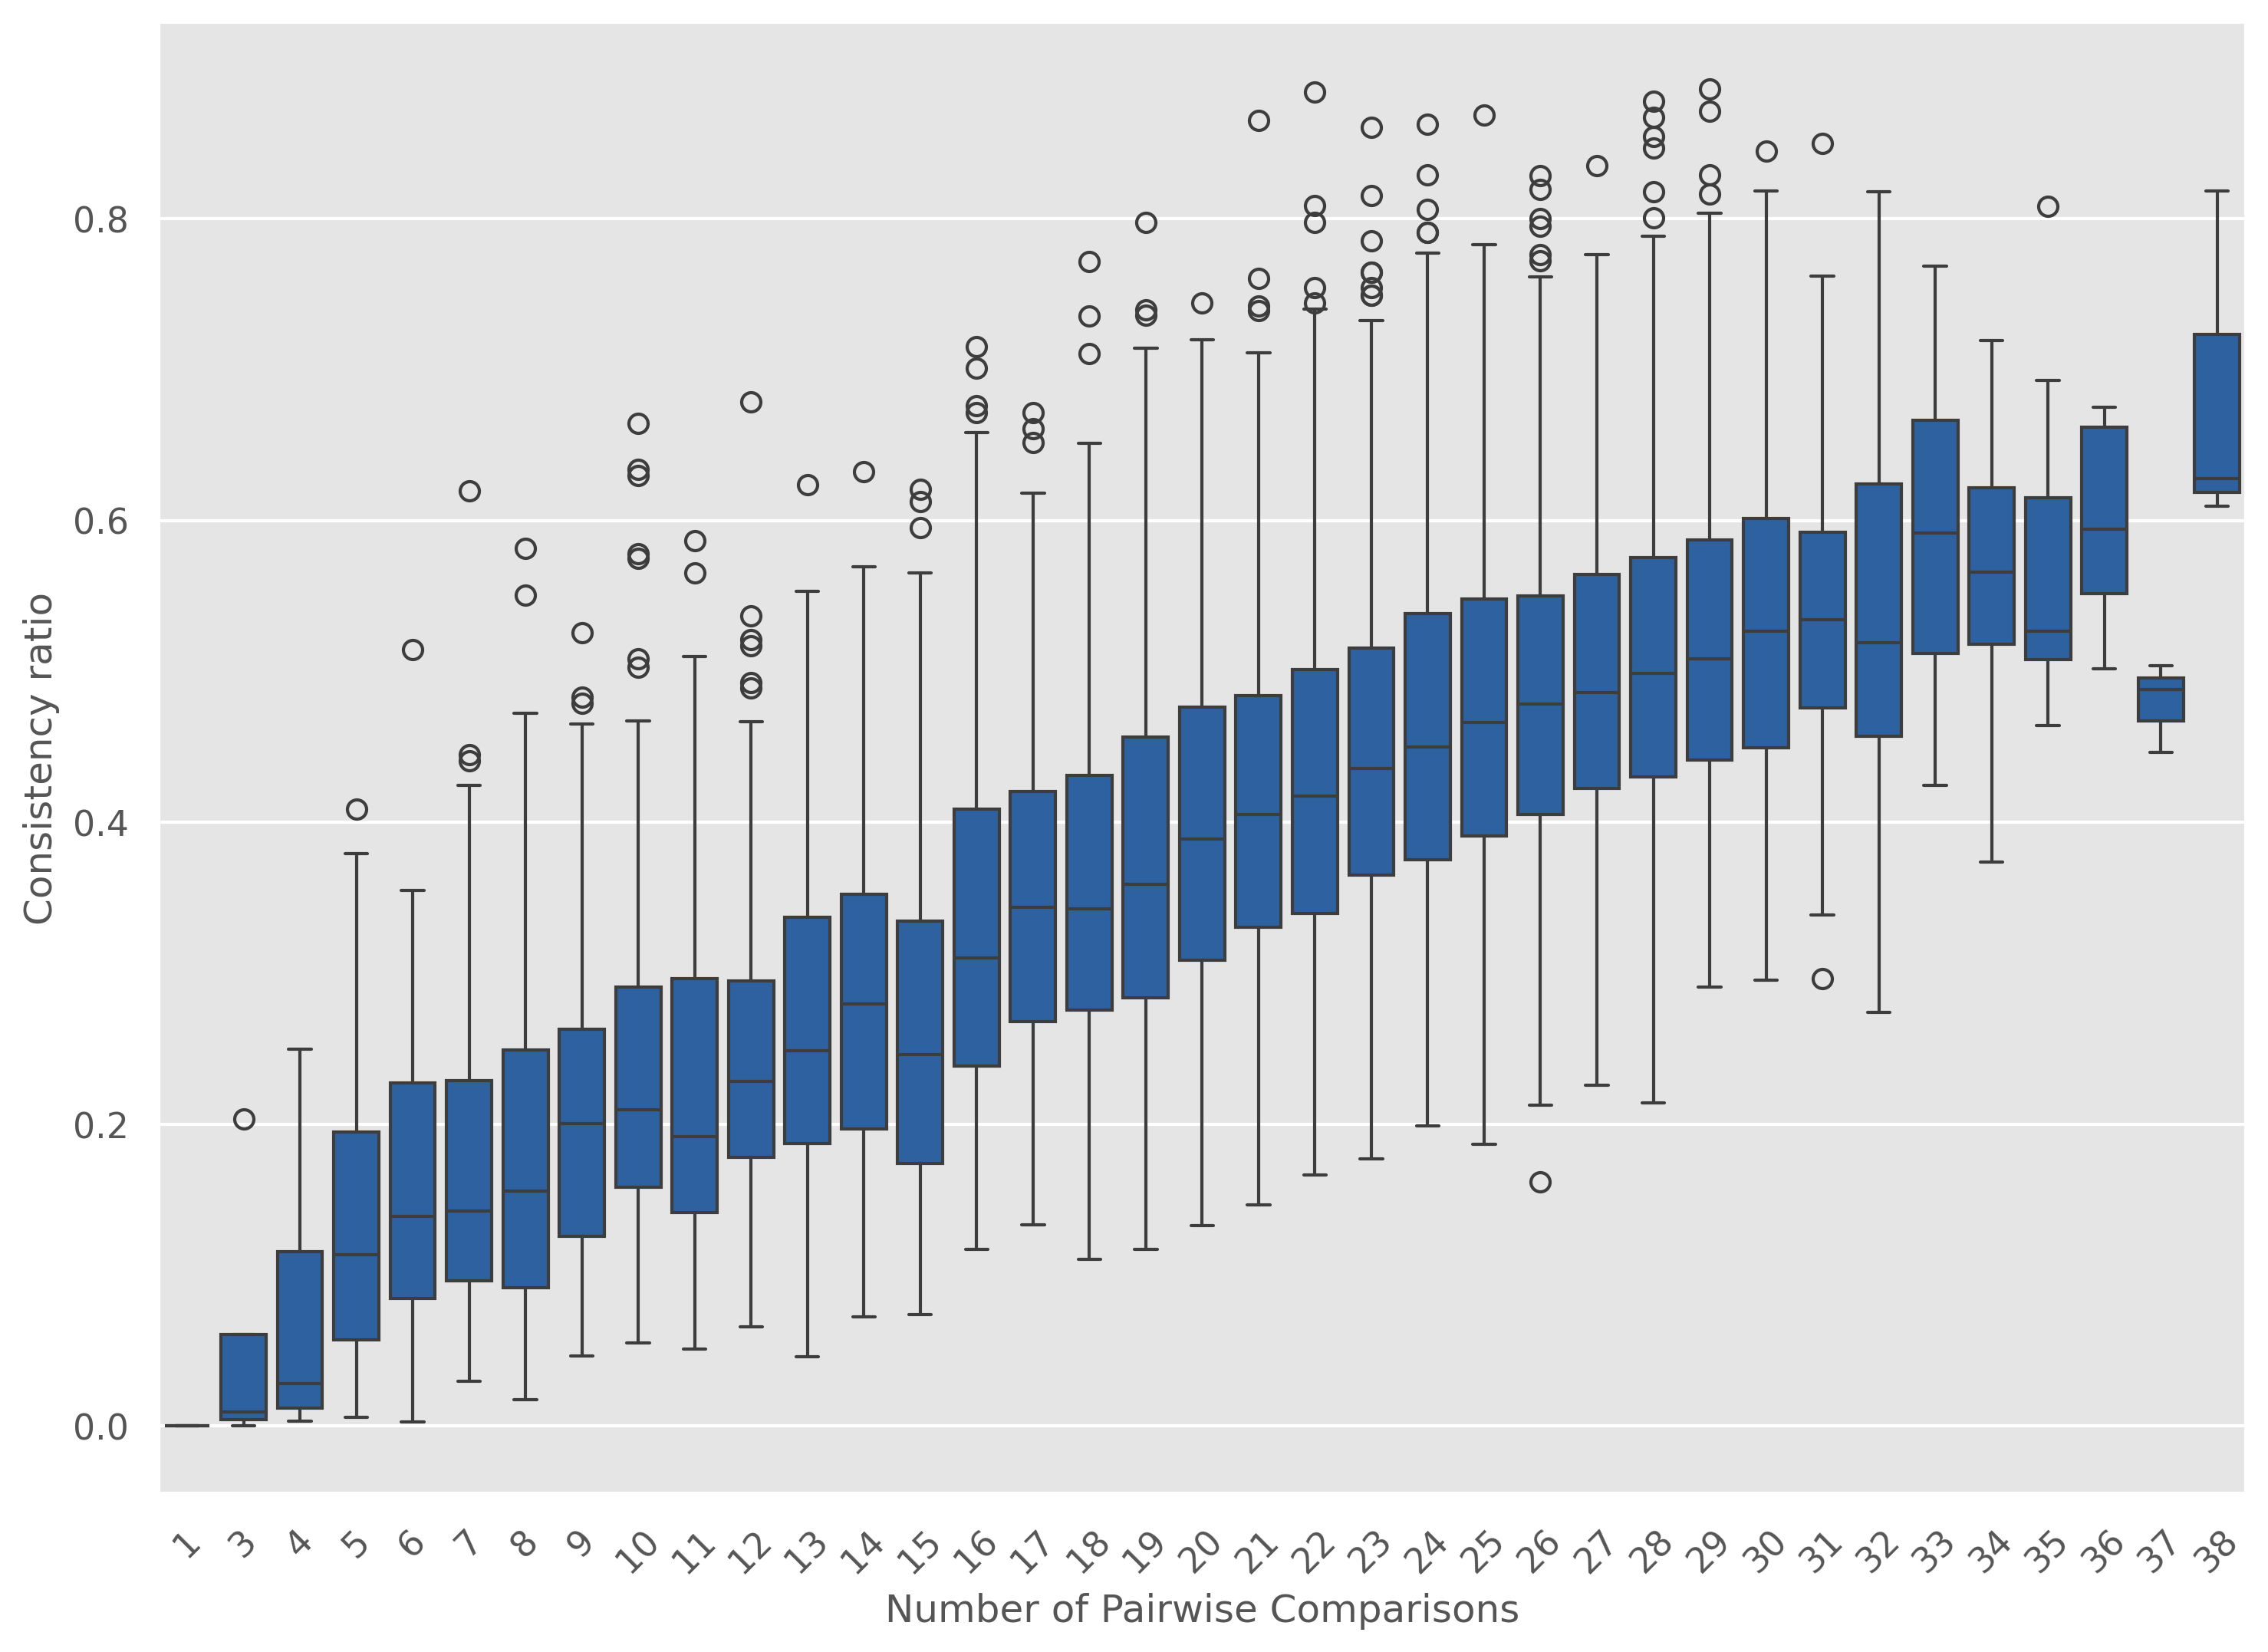

                                       sum_sq      df           F  PR(>F)
C(Number_of_Pairwise_Comparisons)  203.923392    36.0  493.690834     0.0
Residual                           114.314050  9963.0         NaN     NaN


In [25]:
import pandas as pd
results_df = pd.read_csv('/workspaces/Weighted_Heuristics/simulations_results.csv')
results_df.drop('Unnamed: 0',axis=1,inplace=True)
import matplotlib.pyplot as plt
import seaborn as sns
# Set the ggplot-like style
#sns.set(style="ggplot")
plt.style.use('ggplot')
# Define the custom color palette
custom_palette = ["#1a5fb3", "#0b3149", "#1075b7", "#87b9de"]
import numpy as np
from scipy import stats

print(results_df.describe())

def plot_regression(df):
    # Set the figure size and resolution
    plt.figure(figsize=(8, 6), dpi=300)
    
    # Scatter plot with linear regression
    sns.lmplot(x='Consistency Ratio', y='Computing Time (seconds)', data=df, ci=None, height=6, aspect=1.38)

    # Calculating regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['Consistency Ratio'], df['Computing Time (seconds)'])
    
    # Adding regression line equation and R-squared to the plot
    plt.text(0.05, 0.95, f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}', 
             fontsize=12, va='top', ha='left', transform=plt.gca().transAxes)

    plt.title('Consistency Ratio vs. Computing Time')
    plt.xlabel('Consistency Ratio')
    plt.ylabel('Computing Time (seconds)')
    
    plt.show()
    
#plot_regression(results_df)

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

def plot_boxplot_and_anova(df, column):
    # Replace spaces in column names with underscores for formula compatibility
    column_formatted = column.replace(" ", "_")
    pairwise_comparisons_formatted = 'Number_of_Pairwise_Comparisons'
    
    # Update the DataFrame column names
    df = df.rename(columns={column: column_formatted, 'Number of Pairwise Comparisons': pairwise_comparisons_formatted})

    # Set the figure size and resolution
    plt.figure(figsize=(11.7, 8.3), dpi=300)  # A4 size in inches
    
    # Boxplot
    sns.boxplot(x=pairwise_comparisons_formatted, y=column_formatted, data=df, palette=['#1a5fb3'])
    #plt.title(f'{column} grouped by Number of Pairwise Comparisons')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.xlabel('Number of Pairwise Comparisons')
    plt.ylabel('Consistency ratio')
    plt.savefig('Consistency by comparisons.jpg')
    plt.show()

    # ANOVA test
    formula = f'{column_formatted} ~ C({pairwise_comparisons_formatted})'
    model = ols(formula, data=df).fit()
    anova_result = sm.stats.anova_lm(model, typ=2)
    print(anova_result)



plot_boxplot_and_anova(results_df,'Consistency Ratio' )

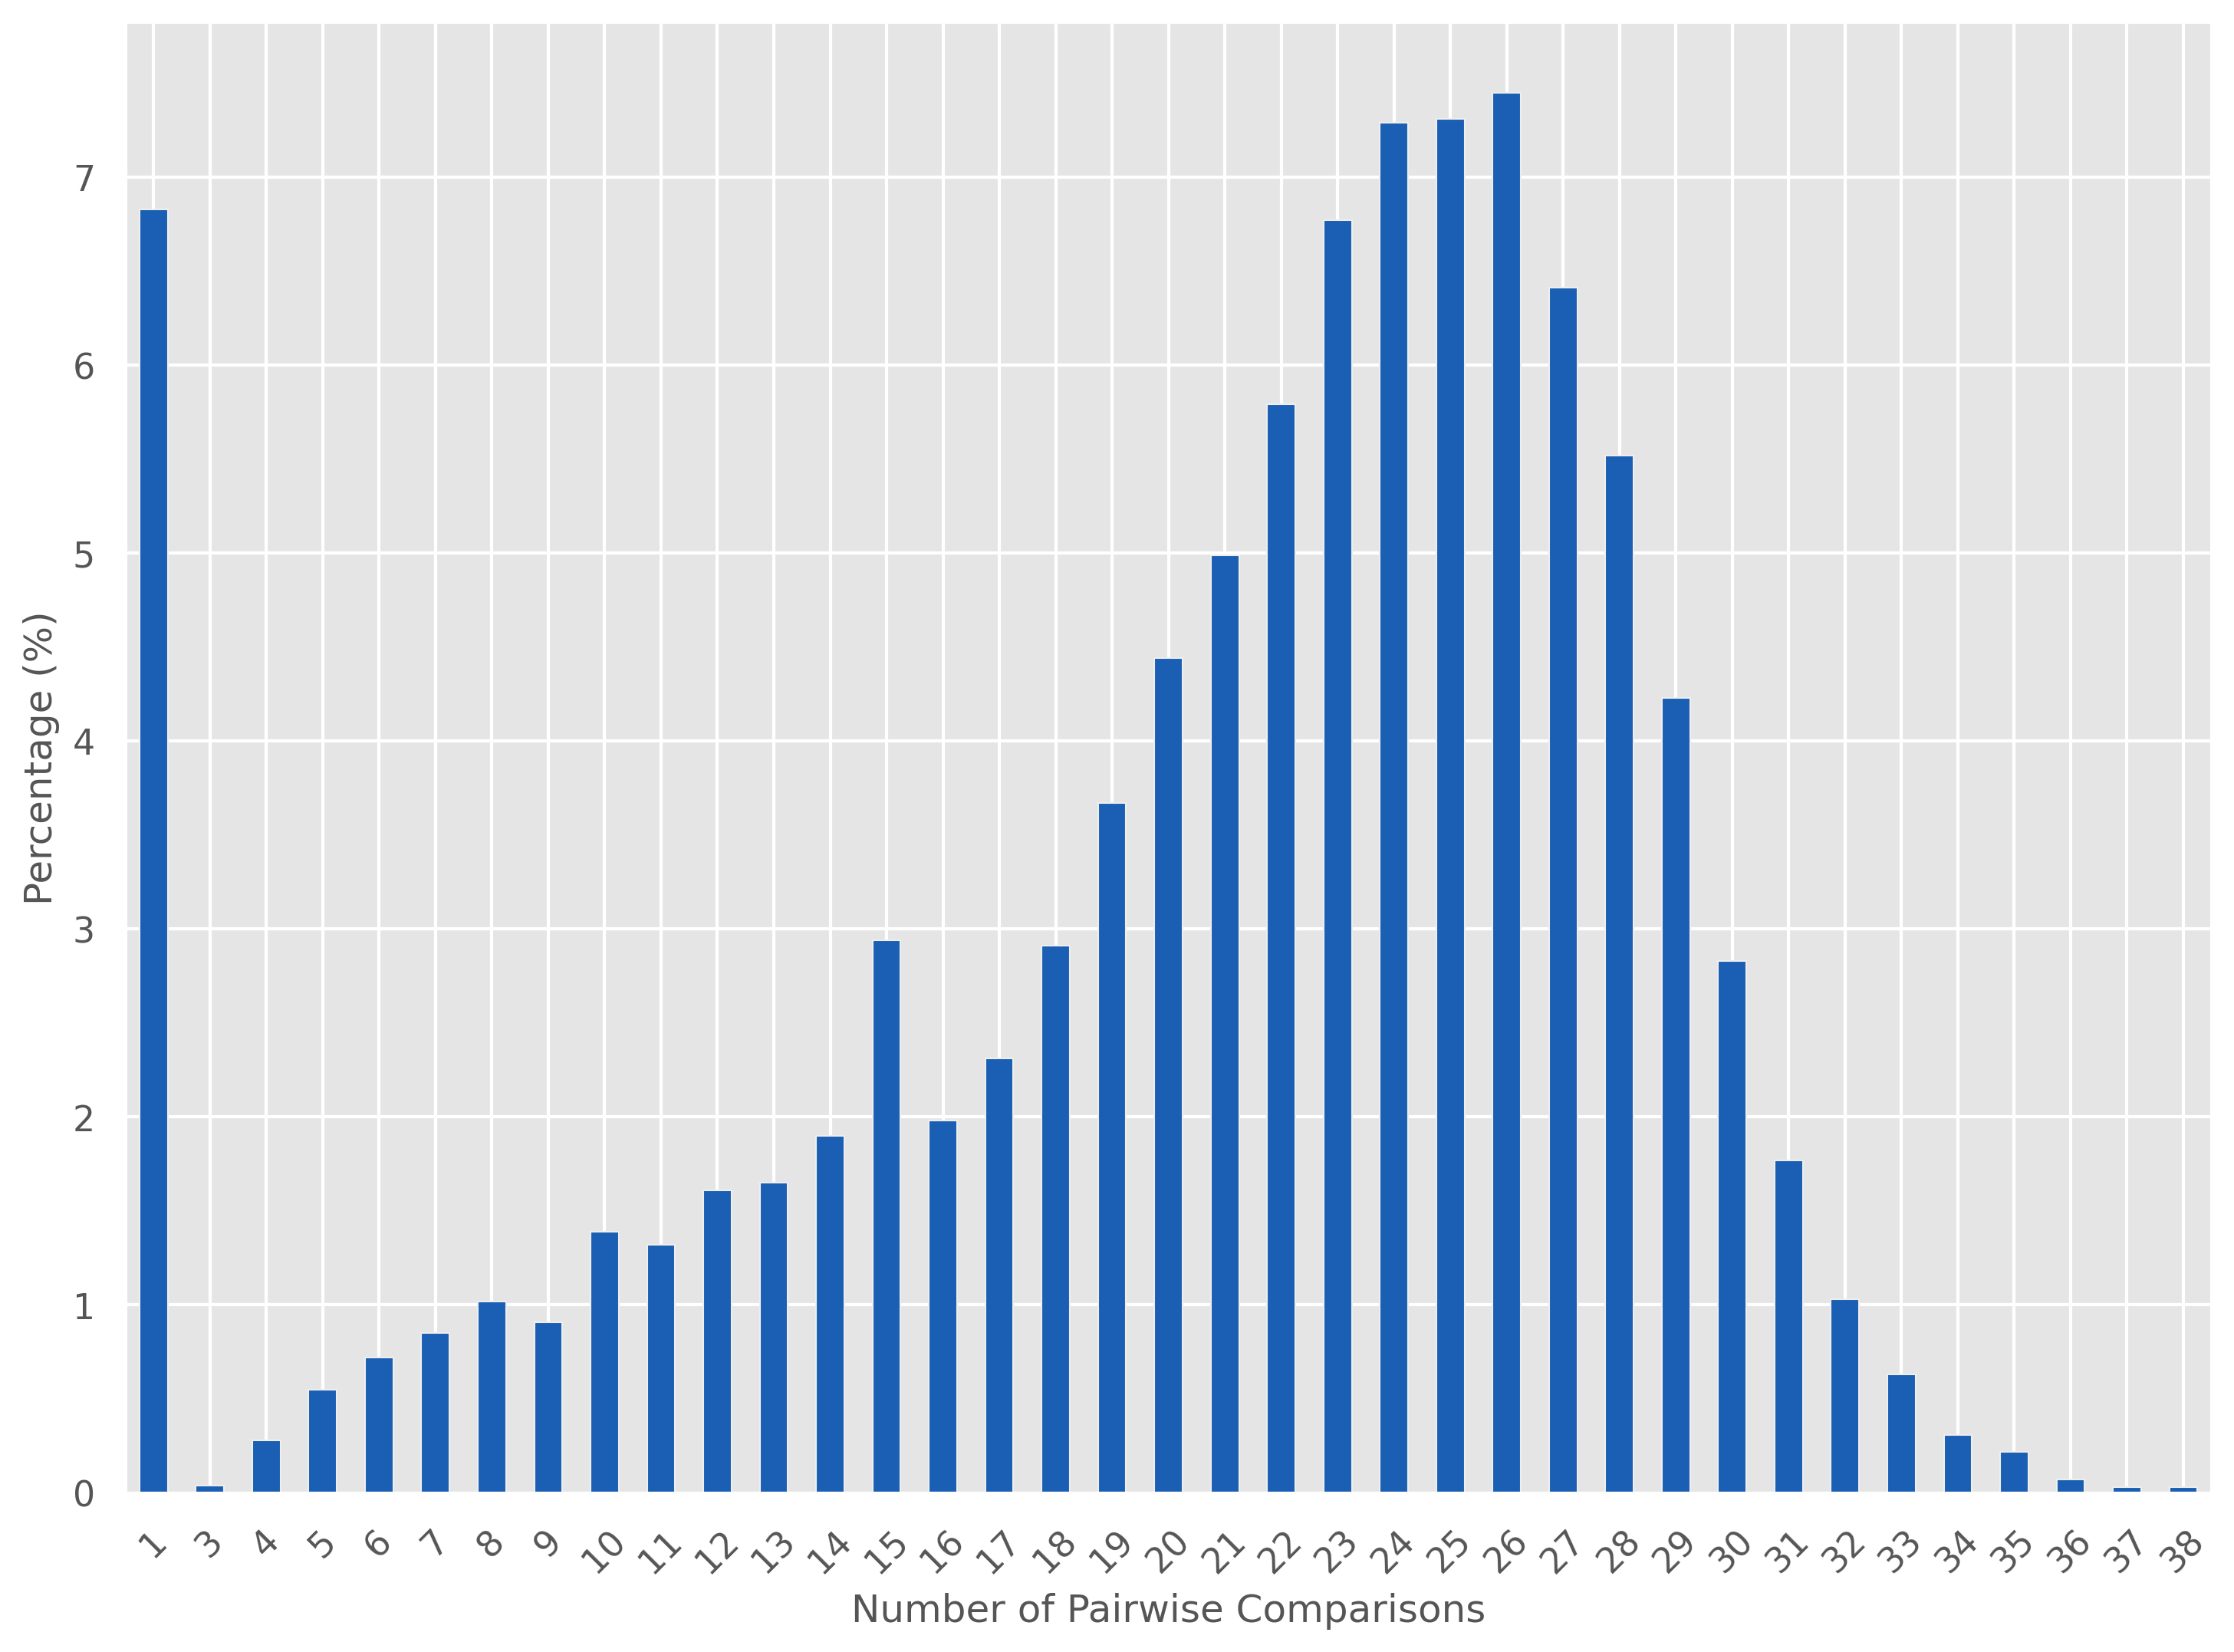

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Define the custom color palette
custom_palette = ["#1a5fb3", "#0b3149", "#1075b7", "#87b9de"]



# Calculate frequency distribution and convert to percentage
freq_distribution = results_df['Number of Pairwise Comparisons'].value_counts(normalize=True) * 100

# Sort by index for orderly plot (optional, depending on your preference)
freq_distribution = freq_distribution.sort_index()

# Create bar plot
# Set the figure size and resolution
plt.figure(figsize=(11.7, 8.3), dpi=300)  # A4 size in inches
freq_distribution.plot(kind='bar',color="#1a5fb3")

# Adding labels and title
plt.xlabel('Number of Pairwise Comparisons')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.ylabel('Percentage (%)')
#plt.title('Frequency Distribution of Number of Pairwise Comparisons')

# Show the plot
plt.savefig('frequency of Pairwise Comparisons.jpg')
plt.show()


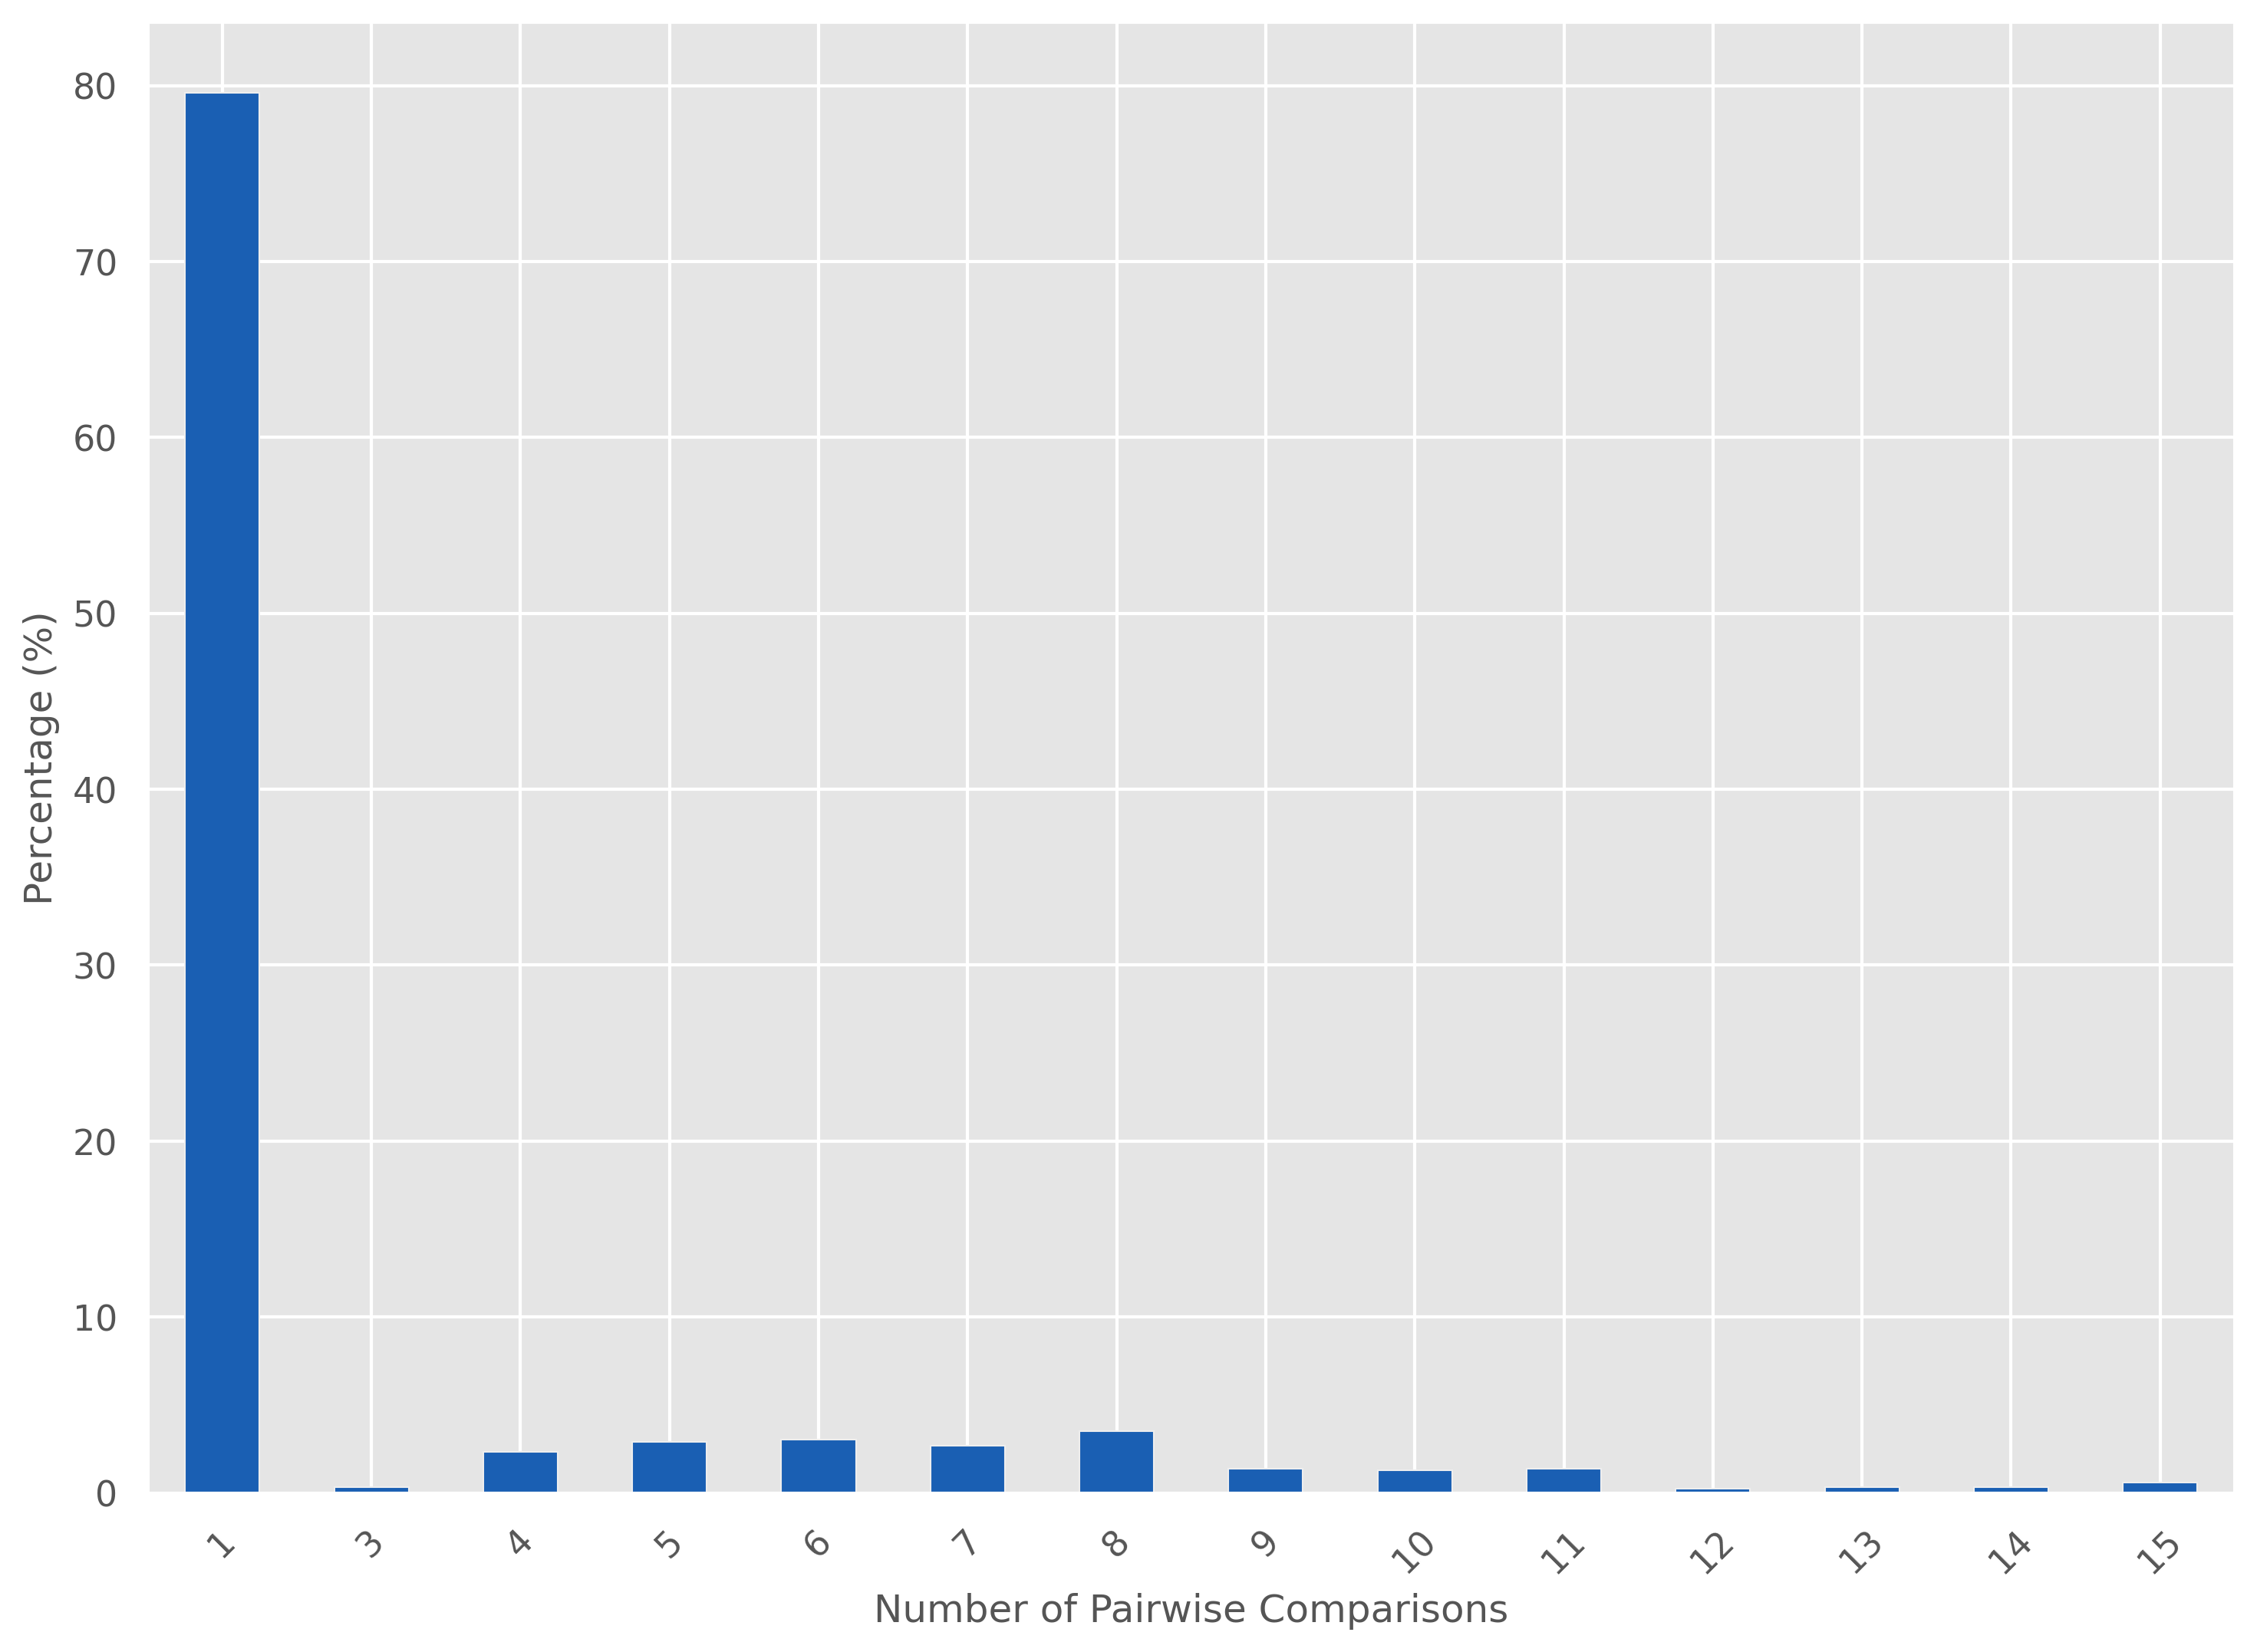

In [38]:
plt.style.use('ggplot')
# Define the custom color palette
custom_palette = ["#1a5fb3", "#0b3149", "#1075b7", "#87b9de"]



# Calculate frequency distribution and convert to percentage
freq_distribution = results_df[results_df['Consistency Ratio']<0.1]['Number of Pairwise Comparisons'].value_counts(normalize=True) * 100

# Sort by index for orderly plot (optional, depending on your preference)
freq_distribution = freq_distribution.sort_index()

# Set the figure size and resolution
plt.figure(figsize=(11.7, 8.3), dpi=300)  # A4 size in inches
freq_distribution.plot(kind='bar',color="#1a5fb3")

# Adding labels and title
plt.xlabel('Number of Pairwise Comparisons')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.ylabel('Percentage (%)')
#plt.title('Frequency Distribution of Number of Pairwise Comparisons')

# Show the plot
plt.savefig('Frequency Distribution of Number of Pairwise Comparisons.jpg')
plt.show()